In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from keplergl import KeplerGl
import requests as req

In [2]:
# Load dataset
dataset_raw = pd.read_csv("../dataset/train.csv")

In [3]:
dataset_raw.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

In [4]:
# Change data types of columns
dataset_raw['pickup_datetime']= pd.to_datetime(dataset_raw['pickup_datetime']) 
dataset_raw['dropoff_datetime']= pd.to_datetime(dataset_raw['dropoff_datetime']) 
dataset_raw = dataset_raw.astype({'vendor_id': 'object'})

In [5]:
dataset_raw.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

## Data Exploration - Mulitivariate

In [6]:
# Describing all the Numerical Features
dataset_raw.describe()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [7]:
# Describing all the Categorical Features
dataset_raw.describe(include=['O'])

,id,vendor_id,store_and_fwd_flag
count,1458644,1458644,1458644
unique,1458644,2,2
top,id2176315,2,N
freq,1,780302,1450599


In [8]:
# OSRM distance
def route_dis(loc1,loc2):
    URL="http://localhost:5000/route/v1/driving/"+loc1+";"+loc2+"?overview=full&alternatives=false&steps=false&geometries=geojson"
    route = "routes"
    distance = "distance"
    duration = "duration"
    geo = "geometry"
    cordinates = "coordinates"
    r = req.get(url=URL)
    data = r.json()
    if(route in data.keys()):
        return data[route][0][distance]
    else:
        -1

dataset_raw["osrm_distance"] = dataset_raw.apply(lambda x: route_dis(str(x.pickup_longitude)+","+str(x.pickup_latitude),str(x.dropoff_longitude)+","+str(x.dropoff_latitude)),axis=1)

In [ ]:
# Hex bin tagging
from h3 import h3

def get_h3ID(pick_lat, pick_lon, drop_lat, drop_lon, res_pick, res_drop):
    pick_ID = h3.geo_to_h3(pick_lat, pick_lon, res_pick)
    drop_ID = h3.geo_to_h3(drop_lat, drop_lon, res_drop)
    return pick_ID,drop_ID

def add_pick_drop_loc_ID(data_frame, res_pick, res_drop):

    df2=data_frame
    try:
        df2['Pick_ID'],df2['Drop_ID'] = zip(*df2.apply(
            lambda row: get_h3ID(
                pick_lat = row['pickup_latitude'],
                pick_lon = row['pickup_longitude'],
                drop_lat = row['dropoff_latitude'],
                drop_lon = row['dropoff_longitude'],
                res_pick = res_pick,
                res_drop = res_drop
            ),
            axis=1
        ))
    except Exception as e:
        print(e)
        pass
add_pick_drop_loc_ID(dataset_raw, res_pick=8, res_drop=8)

In [ ]:
dataset_raw.to_csv("../dataset/dataset_with_hex_and_dis.csv",index=False)

### trip duration

In [9]:
dataset_raw["year"] = dataset_raw.pickup_datetime.dt.year
dataset_raw["month"] = dataset_raw.pickup_datetime.dt.month
dataset_raw["day"] = dataset_raw.pickup_datetime.dt.day
dataset_raw["hour"] = dataset_raw.pickup_datetime.dt.hour
dataset_raw["minute"] = dataset_raw.pickup_datetime.dt.minute
dataset_raw["weekday"] = dataset_raw.pickup_datetime.dt.weekday
dataset_raw["trip_duration_minutes"] = dataset_raw["trip_duration"]/60

In [36]:
dataset_raw.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,year,month,day,hour,minute,weekday,trip_duration_minutes,trip_duration_cats
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016,3,14,17,24,0,7.583333,10 min < T < 20 min
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016,6,12,0,43,6,11.050000,10 min < T < 20 min
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016,1,19,11,35,1,35.400000,30 min < T < 60 min
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016,4,6,19,32,2,7.150000,10 min < T < 20 min
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016,3,26,13,30,5,7.250000,10 min < T < 20 min


In [38]:
# Categorize time duration
def categorize(value):
    if value <= 5:
        return "T < 5 min"
    elif 5 < value <= 10:
        return "5 min < T < 10 min"
    elif 10 < value <= 20:
        return "10 min < T < 20 min"
    elif 20 < value <= 30:
        return "20 min < T < 30 min"
    elif 30 < value <= 60:
        return "30 min < T < 60 min"
    elif 60 < value <= 120:
        return "60 min < T < 120 min"
    else:
        return "120 min > T"
    
dataset_raw["trip_duration_cats"] = dataset_raw["trip_duration_minutes"].apply(lambda x: categorize(x))

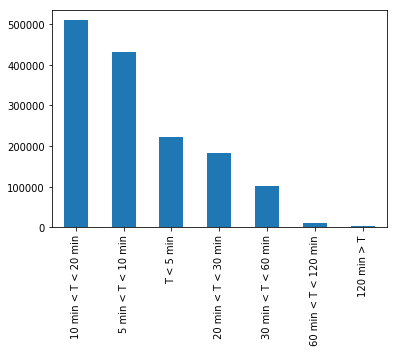

In [39]:
dataset_raw["trip_duration_cats"].value_counts().plot(kind='bar')

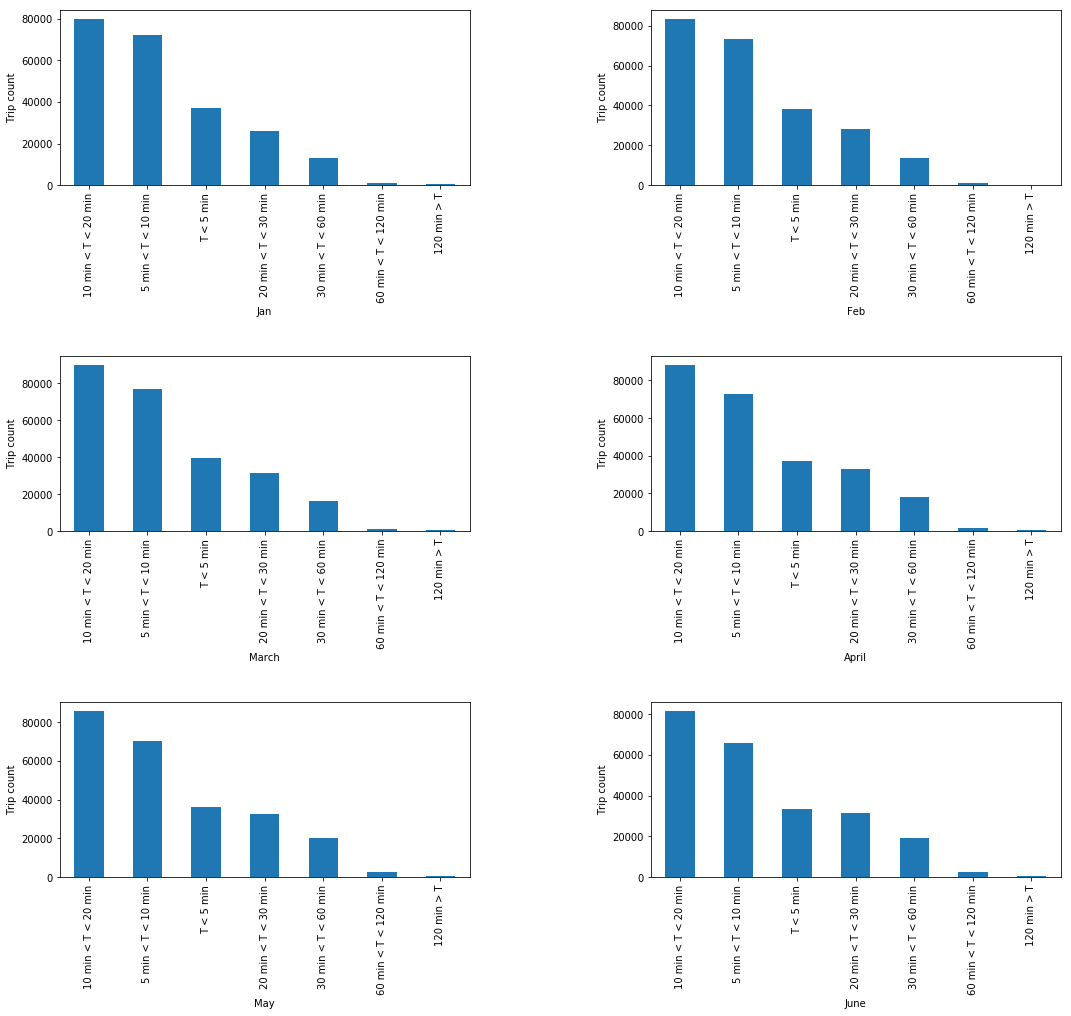

In [43]:
# Month wise trip durations
fig, ax = plt.subplots(3, 2)
fig.set_size_inches(18.5, 16.5)
fig.tight_layout(pad=15.0)
months = ['Jan', 'Feb', 'March', 'April', 'May', 'June']
for i in range(6):
    a = dataset_raw[dataset_raw['month']==i+1]["trip_duration_cats"].value_counts().plot(kind='bar',ax=ax[int(i/2)][i%2])
    a.set_xlabel(months[i])
    a.set_ylabel("Trip count")

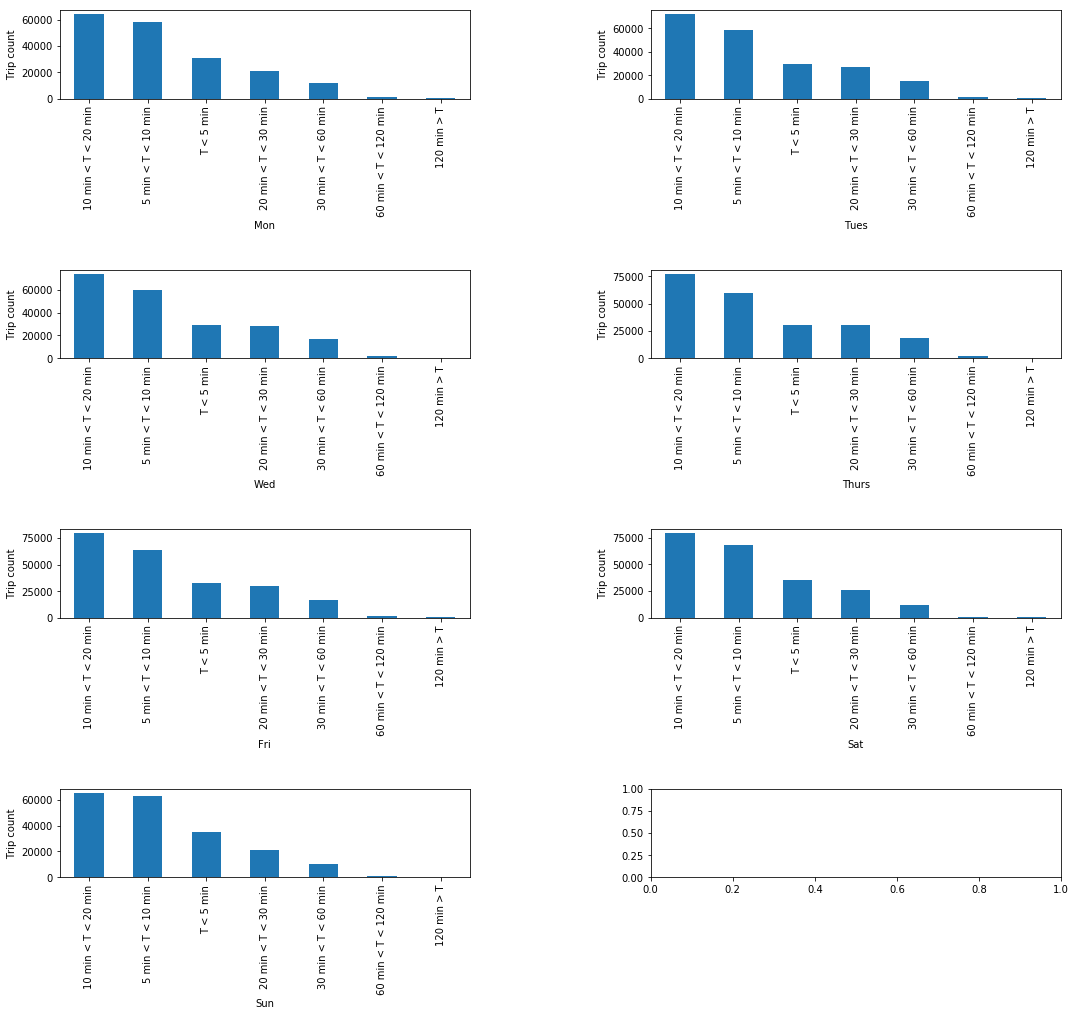

In [44]:
# Day wise trip durations
fig, ax = plt.subplots(4, 2)
fig.set_size_inches(18.5, 16.5)
fig.tight_layout(pad=15.0)
days = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat','Sun']
for i in range(7):
    a = dataset_raw[dataset_raw['weekday']==i]["trip_duration_cats"].value_counts().plot(kind='bar',ax=ax[int(i/2)][i%2])
    a.set_xlabel(days[i])
    a.set_ylabel("Trip count")

In [45]:
#Trips more than 2 hours 
trips_more_than_2_hours = dataset_raw[dataset_raw["trip_duration_cats"] == "120 min > T"]

In [19]:
nyc_map = KeplerGl(height=600, width=800)
# Add data to Kepler
nyc_map.add_data(data=dataset_raw)
nyc_map

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md


KeplerGl(data={'unnamed': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,…